In [1]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import cvxopt as opt # optimization library
from cvxopt import blas, solvers

%matplotlib inline

### Step 0: Sample Data (ETFs)

In [2]:
price_data = pd.read_csv('C:\\Users\\carol\\Desktop\wdata.csv', index_col=0)
return_data = price_data.pct_change().dropna()

#return_data =pd.read_csv('C:\\Users\\carol\\Desktop\\factor_return.csv', index_col=0)

### Step 1: Tree Clustering 

In [3]:
# compute the inverse-variance portfolio
def getIVP(cov, **kargs):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [4]:
corr = return_data.corr()
cov = return_data.cov()

In [5]:
# define distance measure based on correlation, where 0<=d[i,j]<=1
def correlDist(corr):
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [6]:
def tree_clustering(dist_mat, method="single", metric =  'eculidean'):
    flat_dist_mat = squareform(dist_mat) # 转为一维的distance array
    res_linkage = linkage(flat_dist_mat, method=method, metric = metric)
    return res_linkage

dist = correlDist(corr)
res_linkage = tree_clustering(dist)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

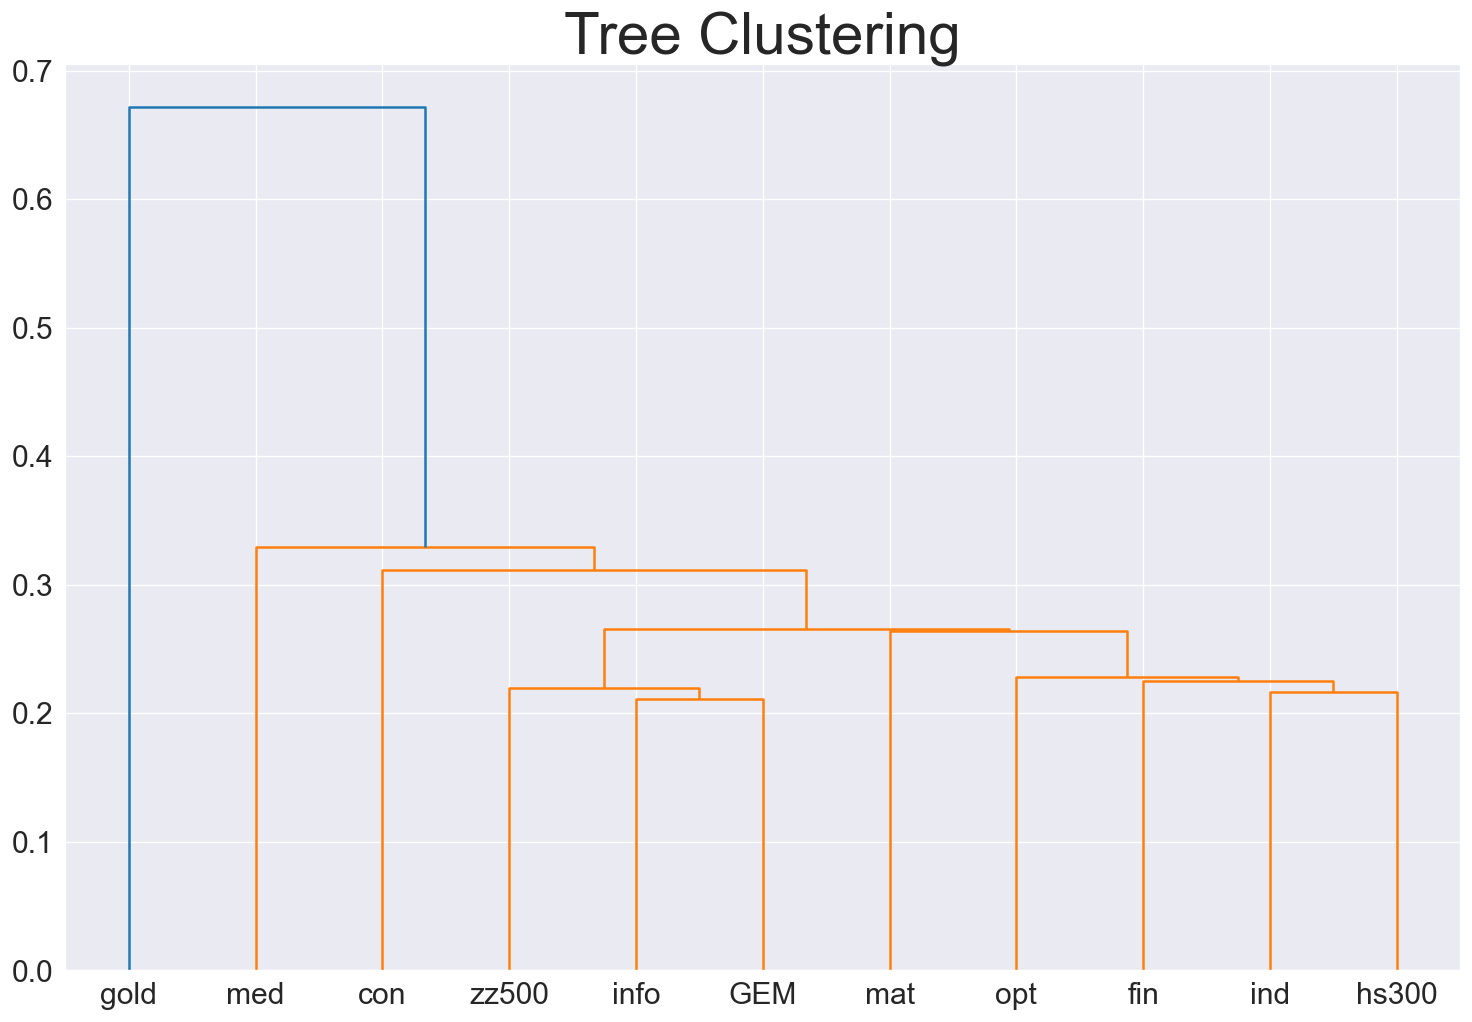

In [7]:
import seaborn as sns
# sns.set_context("talk")
sns.set_style("darkgrid")
plt.figure(figsize=(15,10),dpi=120)
dn = dendrogram(res_linkage, labels=corr.index.values) 
plt.title('Tree Clustering', fontsize=35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


### Step 2: Quasi diagonalization

In [8]:
# compute variance per cluster
def getClusterVar(cov,cItems):
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [9]:
# sort clusters by distance
def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

### Step 3 Recursive Bisection

In [10]:

# compute HRP allocation
def getRecBipart(cov, sortIx):
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [11]:
# construct hierarchical portfolio
def getHRP(cov, corr):
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [12]:
hrp = getHRP(cov, corr)

<ipython-input-11-196c299d8b46>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')


In [13]:
hrp.sort_index()

GEM      0.023375
con      0.029660
fin      0.138468
gold     0.506561
hs300    0.071966
ind      0.030829
info     0.021591
mat      0.053057
med      0.031534
opt      0.032160
zz500    0.060799
dtype: float64